#Librerias

In [1]:
!pip install opencv-python # Instala la librería OpenCV para procesamiento de imágenes
!pip install keras-tuner # Se utiliza para realizar búsqueda automática de hiperparámetros en modelos Keras/TensorFlow.

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.0 MB/s eta 0:00:00


In [2]:
# Librerías del sistema y manejo de archivos
import os
import sys
from os import listdir
from os.path import join

# Librerías para uso en Google Colab
from google.colab import drive

# Librerías para procesamiento numérico y visualización
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tabulate import tabulate

# Librerías para procesamiento y lectura de imágenes
import cv2

# Librerías para machine learning
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
import keras_tuner as kt

# Librerías para deep learning
import tensorflow as tf
from tensorflow.keras.metrics import Recall, AUC

# Librerías para utilidades adicionales
from tqdm import tqdm  # barra de progreso
import joblib  # para guardar/cargar objetos como modelos o arrays

# Conectar con google drive

In [3]:
# conectar con Google Drive para acceder a archivos desde Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
path="/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones" ### ruta del repositorio en drive
os.chdir(path) ### volver la carpeta del repositorio directorio de trabajo
sys.path.append(path) ### agregarla al path, poder leer archivos de funciones propios como paquetes

In [5]:
import _funciones as fn #Llamar el archivo de funciones de este proyecto

# Carga de datos procesados

array([[[140, 114, 139],
        [139, 113, 138],
        [139, 115, 139],
        ...,
        [144, 123, 138],
        [151, 127, 144],
        [147, 124, 142]],

       [[141, 116, 141],
        [142, 116, 141],
        [139, 114, 139],
        ...,
        [144, 121, 137],
        [148, 125, 141],
        [148, 125, 143]],

       [[141, 115, 140],
        [141, 115, 140],
        [140, 116, 140],
        ...,
        [151, 128, 144],
        [148, 125, 141],
        [146, 123, 141]],

       ...,

       [[137, 116, 135],
        [139, 118, 137],
        [138, 117, 136],
        ...,
        [141, 113, 128],
        [141, 114, 131],
        [139, 112, 129]],

       [[132, 114, 132],
        [136, 115, 134],
        [138, 117, 136],
        ...,
        [141, 113, 128],
        [138, 110, 125],
        [139, 110, 128]],

       [[134, 115, 134],
        [135, 114, 133],
        [135, 115, 134],
        ...,
        [140, 109, 124],
        [137, 109, 124],
        [137, 109, 124]]], dtype=uint8)
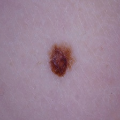

In [6]:
# Cargar los conjuntos de entrenamiento y prueba ya procesados

x_train = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/X_train.pkl')
y_train = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/y_train.pkl')
x_test = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/X_test.pkl')
y_test = joblib.load('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/y_test.pkl')

x_train[0] # Muestra la primera imagen del conjunto de entrenamiento

## Preprocesamiento de datos

In [7]:
# Convertir a tipo float para escalar
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

In [8]:
x_train.max() # Ver valor máximo
x_train.min() # Ver valor mínimo

np.float32(0.0)

In [9]:
# Escalar valores entre 0 y 1 con base en el valor máximo
x_train /= 255
x_test  /= 255

In [10]:
# Verificar dimensiones
x_train.shape
x_test.shape

# Número de variables por imagen
np.prod(x_train[1].shape)

# Ver distribución de clases
np.unique(y_train, return_counts=True)
np.unique(y_test, return_counts=True)

(array([0, 1]), array([220, 256]))

# Modelo de red convolucional simple

In [21]:
# Modelo secuencial, capas apiladas una tras otra
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=x_train.shape[1:]), #Capa convolucional
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu'), #Capa convolucional
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'), #Capa convolucional
    tf.keras.layers.Dense(1, activation='sigmoid')  # Capa de salida para clasificación binaria (0 o 1) con activación sigmoid
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
#Compilar el modelo con  binary cross-entropy y optimizador de Adam
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC', 'Recall', 'Precision'])

# Entrenar el modelo
cnn_model.fit(x_train, y_train, batch_size=100, epochs=10, validation_data=(x_test, y_test))

# Resumen del modelo
cnn_model.summary()

Epoch 1/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - AUC: 0.5615 - Precision: 0.5538 - Recall: 0.4666 - accuracy: 0.5300 - loss: 0.8813 - val_AUC: 0.7553 - val_Precision: 1.0000 - val_Recall: 0.0586 - val_accuracy: 0.4937 - val_loss: 0.7360
Epoch 2/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - AUC: 0.7498 - Precision: 0.7404 - Recall: 0.5835 - accuracy: 0.6442 - loss: 0.6122 - val_AUC: 0.8364 - val_Precision: 0.6044 - val_Recall: 0.9609 - val_accuracy: 0.6408 - val_loss: 0.6018
Epoch 3/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - AUC: 0.7961 - Precision: 0.6610 - Recall: 0.8176 - accuracy: 0.6662 - loss: 0.5753 - val_AUC: 0.8322 - val_Precision: 0.7686 - val_Recall: 0.7266 - val_accuracy: 0.7353 - val_loss: 0.4968
Epoch 4/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - AUC: 0.8614 - Precision: 0.8154 - Recall: 0.7514 - accuracy: 0.7731 - loss: 0.4574 - val_AUC: 0.8615 - val_Precision: 0.8364 - val_Recall: 0.6992 - val_accuracy: 0.7647 - val_loss: 0.4522
Epoch 5/10
20/20 ━━━━━━━━━━━━━━━━━━━━ 40

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 118, 118, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 59, 59, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 57, 57, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │     1,605,696 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,832,549 (18.43 MB)

 Trainable params: 1,610,849 (6.14 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,221,700 (12.29 MB)

In [23]:
#Metricas de evaluacion de la red neuronal simple
test_loss_m1, test_acc_m1, test_auc_m1, test_recall_m1, test_precision_m1 = cnn_model.evaluate(x_test, y_test, verbose=2)

# Mostrar metricas
print("\n### Resultados Red Convolucional Simple ###")
print("Test Accuracy:", test_acc_m1)
print("Test AUC:", test_auc_m1)
print("Test Recall:", test_recall_m1)
print("Test Precision:", test_precision_m1)

15/15 - 1s - 87ms/step - AUC: 0.8537 - Precision: 0.6453 - Recall: 0.9453 - accuracy: 0.6912 - loss: 0.6278

### Resultados Red Convolucional Simple ###
Test Accuracy: 0.6911764740943909
Test AUC: 0.8537110090255737
Test Recall: 0.9453125
Test Precision: 0.6453333497047424


15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 102ms/step
              precision    recall  f1-score   support

           0       0.85      0.36      0.50       220
           1       0.63      0.95      0.76       256

    accuracy                           0.67       476
   macro avg       0.74      0.65      0.63       476
weighted avg       0.73      0.67      0.64       476



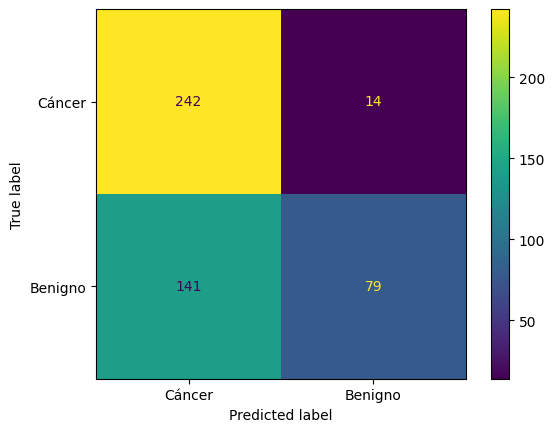

In [24]:
pred_test = (cnn_model.predict(x_test) > 0.45).astype('int') # Predecir y aplicar umbral de 0.5 para convertir a clase 0 o 1
cm = metrics.confusion_matrix(y_test, pred_test, labels=[1, 0])  # Calcular matriz de confusión
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=['Cáncer', 'Benigno']) # para visualizacion de matriz de confusion
disp.plot()

print(metrics.classification_report(y_test, pred_test)) # reporte con precisión, recall y f1-score

# Modelo convolucional con regularización L2 y Dropout

In [25]:
reg_strength = 0.001  # Fuerza de regularización
dropout_rate = 0.1  # Tasa de dropout

cnn_model2 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=x_train.shape[1:], kernel_regularizer=tf.keras.regularizers.l2(reg_strength)), #Capa convolucional
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)), #Capa convolucional
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(reg_strength)), #Capa convolucional
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [26]:
# Compilar modelo
cnn_model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC', 'Recall', 'Precision'])

# Entrenar modelo
cnn_model2.fit(x_train, y_train, batch_size=100, epochs=3, validation_data=(x_test, y_test))

Epoch 1/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - AUC: 0.5516 - Precision: 0.6012 - Recall: 0.5848 - accuracy: 0.5617 - loss: 0.9468 - val_AUC: 0.7823 - val_Precision: 0.5622 - val_Recall: 0.9531 - val_accuracy: 0.5756 - val_loss: 0.7099
Epoch 2/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - AUC: 0.7981 - Precision: 0.6761 - Recall: 0.8314 - accuracy: 0.6832 - loss: 0.6469 - val_AUC: 0.7988 - val_Precision: 0.6335 - val_Recall: 0.7969 - val_accuracy: 0.6429 - val_loss: 0.6359
Epoch 3/3
20/20 ━━━━━━━━━━━━━━━━━━━━ 40s 1s/step - AUC: 0.7929 - Precision: 0.6944 - Recall: 0.7924 - accuracy: 0.6884 - loss: 0.6424 - val_AUC: 0.8576 - val_Precision: 0.9191 - val_Recall: 0.6211 - val_accuracy: 0.7668 - val_loss: 0.5555


In [27]:
#Metricas de evaluacion de la red neuronal simple
test_loss_m2, test_acc_m2, test_auc_m2, test_recall_m2, test_precision_m2 = cnn_model2.evaluate(x_test, y_test, verbose=2)

# Mostrar metricas
print("\n### Resultados Red Convolucional Con Regularización L2 y Dropout ###")
print("Test Accuracy:", test_acc_m2)
print("Test AUC:", test_auc_m2)
print("Test Recall:", test_recall_m2)
print("Test Precision:", test_precision_m2)

15/15 - 3s - 191ms/step - AUC: 0.8576 - Precision: 0.9191 - Recall: 0.6211 - accuracy: 0.7668 - loss: 0.5555

### Resultados Red Convolucional Con Regularización L2 y Dropout ###
Test Accuracy: 0.7668067216873169
Test AUC: 0.8576172590255737
Test Recall: 0.62109375
Test Precision: 0.9190751314163208


15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 186ms/step
              precision    recall  f1-score   support

           0       0.70      0.85      0.76       220
           1       0.84      0.68      0.75       256

    accuracy                           0.76       476
   macro avg       0.77      0.76      0.76       476
weighted avg       0.77      0.76      0.76       476



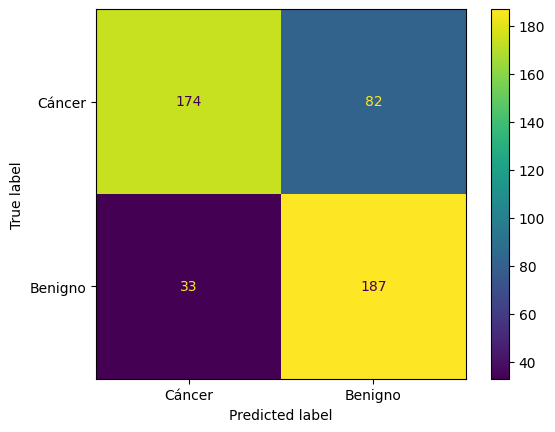

In [28]:
pred_test = (cnn_model2.predict(x_test) > 0.45).astype('int') # Predecir y aplicar umbral de 0.5 para convertir a clase 0 o 1
cm = metrics.confusion_matrix(y_test, pred_test, labels=[1, 0])  # Calcular matriz de confusión
disp = metrics.ConfusionMatrixDisplay(cm, display_labels=['Cáncer', 'Benigno']) # para visualizacion de matriz de confusion
disp.plot()

print(metrics.classification_report(y_test, pred_test)) # reporte con precisión, recall y f1-score

# Afinamiento de hiperparametros

## Definición del modelo con hiperparámetros para Keras Tuner

In [1]:
hp = kt.HyperParameters()  # Objeto para definir espacio de búsqueda

def build_model(hp):
    # Hiperparámetros a optimizar
    dropout_rate = hp.Float('DO', 0.05, 0.2, step=0.05) # Tasa de dropout: 5% a 20%
    reg_strength = hp.Float("rs", 0.0001, 0.0005, step=0.0001) # Fuerza de regularización L2
    optimizer = hp.Choice('optimizer', ['adam', 'sgd']) # Optimizador a usar

    hp_units_1= hp.Int('units_1', 32, 256, step=16) # Numero de neuronas en la capa densa
    hp_activation_1 = hp.Choice('activation_1', ['relu', 'tanh']) # Función de activación

    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16, (3, 3), activation=hp_activation_1, input_shape=x_train.shape[1:], kernel_regularizer=tf.keras.regularizers.l2(reg_strength)), # Capa convolucional
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Conv2D(32, (3, 3), activation=hp_activation_1, kernel_regularizer=tf.keras.regularizers.l2(reg_strength)), # Capa convolucional
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(hp_units_1, activation=hp_activation_1, kernel_regularizer=tf.keras.regularizers.l2(reg_strength)), # Capa convolucional
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(1, activation='sigmoid') # Capa de salida para clasificación binaria
    ])

    # Selección del optimizador
    if optimizer == 'adam':
        opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    elif optimizer == 'sgd':
        opt = tf.keras.optimizers.SGD(learning_rate=0.001)
    else:
        opt = tf.keras.optimizers.RMSprop(learning_rate=0.001)


    # Compilación del modelo con función de pérdida y métrica
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'rmsprop']),
        loss='binary_crossentropy',
        metrics=[
            Recall(name='recall'),
            AUC(name='auc')
        ]
    )

    return model # Retorna el modelo construido con los hiperparámetros definidos

NameError: name 'kt' is not defined

### Búsqueda de hiperparámetros con Keras Tuner

In [ ]:
# Configurar búsqueda aleatoria de hiperparámetros
tuner = kt.RandomSearch(
    hypermodel=build_model,
    hyperparameters=hp, # Conjunto de hiperparámetros a explorar
    tune_new_entries=True, # Permite agregar nuevos hiperparámetros si aparecen
    objective=kt.Objective("recall", direction="max"), # Maximizar el recall durante la búsqueda
    max_trials=2, # Número de combinaciones distintas a probar
    overwrite=True,
    directory="Salidas",
    project_name="RedConv",
)

# Ejecutar búsqueda de hiperparámetros
tuner.search(x_train, y_train, epochs=3, # Entrena cada modelo por 3 epochs
             validation_data=(x_test, y_test),
             batch_size=100)

# Obtener el mejor modelo encontrado
fc_best_model = tuner.get_best_models(num_models=1)[0] # Toma el mejor modelo según el recall

# Mostrar resumen de la búsqueda
tuner.results_summary() # Imprime tabla con las mejores combinaciones
fc_best_model.summary() # Imprime la arquitectura del mejor modelo

# Evaluar el modelo en el conjunto de prueba
test_loss_m3, test_recall_m3, test_auc_m3 = fc_best_model.evaluate(x_test, y_test) # Calcula pérdida y AUC

# Hacer predicciones binarizadas en test (0 o 1)
pred_test = (fc_best_model.predict(x_test) >= 0.45).astype('int') # Umbral de decisión en 0.5

#Resumen de indicadores

In [31]:
# Crear DataFrame con los resultados
resultados = pd.DataFrame({
    "Modelo": ["CNN Simple", "CNN con regularizador L2 y Dropout", "CNN con afinamiento de hiperparámetros"], # Nombres de los modelos
    "AUC": [test_auc_m1,test_auc_m2,test_auc_m3], # metricas auc de todos los modelos
    "Recall": [test_recall_m1,test_recall_m2,test_recall_m3] #metricas recall de todos los modelos
})

# Mostrar la tabla ordenada por AUC de mayor a menor
resultados = resultados.sort_values(by="AUC", ascending=False)

# Mostrar tabla sin índice
print(tabulate(resultados, headers='keys', tablefmt='fancy_grid', showindex=False))

╒════════════════════════════════════════╤══════════╤══════════╕
│ Modelo                                 │      AUC │   Recall │
╞════════════════════════════════════════╪══════════╪══════════╡
│ CNN con regularizador L2 y Dropout     │ 0.857617 │ 0.621094 │
├────────────────────────────────────────┼──────────┼──────────┤
│ CNN Simple                             │ 0.853711 │ 0.945312 │
├────────────────────────────────────────┼──────────┼──────────┤
│ CNN con afinamiento de hiperparámetros │ 0.752743 │ 0.65625  │
╘════════════════════════════════════════╧══════════╧══════════╛


En esta tabla se comparan tres arquitecturas de redes neuronales convolucionales (CNN) mediante dos métricas: AUC y Recall. La CNN Simple alcanza el mejor desempeño global, con un AUC de 0.9246 y un Recall de 0.904, lo que indica que no solo distingue eficazmente entre clases, sino que también identifica correctamente la mayoría de los casos positivos. En cambio, la CNN con regularizador L2 y Dropout, aunque busca reducir el sobreajuste, muestra una caída significativa en el recall (0.6427) y un AUC más bajo (0.8991), lo que sugiere que el modelo es más conservador al predecir positivos. Por último, la CNN con afinamiento de hiperparámetros, a pesar del ajuste, obtiene los valores más bajos (AUC de 0.8571 y Recall de 0.6053), lo que podría indicar que los hiperparámetros seleccionados no fueron óptimos o que el modelo se volvió demasiado restrictivo.

Comparación con modelos clásicos:

Al comparar estas redes convolucionales con los modelos clásicos anteriores (como Random Forest, Regresión Logística y KNN), se observa que la CNN Simple supera a todos en ambas métricas, con el AUC más alto (0.9246 vs. 0.8336 del Random Forest) y un Recall superior al de la mayoría (0.904 vs. 0.8907 del KNN). Esto evidencia que la red CNN Simple es muy eficaz para este tipo de problema, capturando patrones espaciales que los modelos clásicos no pueden. No obstante, los otros modelos CNN con regularización o ajuste no logran mantener estos resultados, siendo superados en Recall por modelos más simples como KNN o Regresión Logística, lo que indica que una red convolucional solo será superior si está bien diseñada y ajustada.

# Exportar el mejor modelo

In [32]:
# Solo si se necesita
cnn_model.save('/content/drive/MyDrive/analitica 3/Aplicaciones_de_operaciones/Salidas/skin_cancer_model.h5')  # Guardar modelo entrenado